In [1]:
"""
MIT License

Copyright (c) 2023 Oscar Riveros

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

'\nMIT License\n\nCopyright (c) 2023 Oscar Riveros\n\nPermission is hereby granted, free of charge, to any person obtaining a copy\nof this software and associated documentation files (the "Software"), to deal\nin the Software without restriction, including without limitation the rights\nto use, copy, modify, merge, publish, distribute, sublicense, and/or sell\ncopies of the Software, and to permit persons to whom the Software is\nfurnished to do so, subject to the following conditions:\n\nThe above copyright notice and this permission notice shall be included in all\ncopies or substantial portions of the Software.\n\nTHE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR\nIMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,\nFITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE\nAUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER\nLIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FRO

### Note: There is an experimental Deep Learning Model for the Sum Subset Problem, is very limited, and only an experimental try.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import satx

2023-09-22 11:54:25.282954: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-22 11:54:25.619225: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-22 11:54:25.623512: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 11:54:27.155749: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# get SLIME SAT Solver (The TOP 1 in the World! :)
!git clone https://github.com/maxtuno/SLIME
!cmake -DCMAKE_BUILD_TYPE=Release SLIME ..
!make
!mv ./SLIME/bin/slime ./slime

Cloning into 'SLIME'...
remote: Enumerating objects: 1552, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 1552 (delta 54), reused 19 (delta 10), pack-reused 1451
Receiving objects: 100% (1552/1552), 12.10 MiB | 12.52 MiB/s, done.
Resolving deltas: 100% (827/827), done.
-- Configuring done
-- Generating done
-- Build files have been written to: /home/maxtuno/development/hess/Hyperconvergent-Prompt-Engineering
Consolidate compiler generated dependencies of target slime
[ 16%] Building CXX object CMakeFiles/slime.dir/src/Ls.cc.o
[ 33%] Building CXX object CMakeFiles/slime.dir/src/Main.cc.o
[ 50%] Building CXX object CMakeFiles/slime.dir/src/Options.cc.o
[ 66%] Building CXX object CMakeFiles/slime.dir/src/SimpSolver.cc.o
[ 83%] Building CXX object CMakeFiles/slime.dir/src/Solver.cc.o
[100%] Linking CXX executable SLIME/bin/slime
[100%] Built target slime


In [4]:
def gen_data(bits, size, context_size, number_of_samples, verbose=False):
    input_data = []
    output_data = []
    if context_size < bits:
        print('Invalid parameters...')
        return [], []
    while len(input_data) < number_of_samples:
        inputs = []
        outputs = []
        universe =[random.randint(1, 2 ** bits) for _ in range(size)]
        t = sum(random.sample(universe, k=size // 2))
        if context_size > t.bit_length():
            satx.engine(t.bit_length(), cnf_path='tmp.cnf')
            x = satx.tensor(dimensions=(len(universe)))
            assert sum(x[[i]](0, universe[i]) for i in range(len(universe))) == t
            if satx.satisfy(solver='./slime'):
                sub = [universe[i] for i in range(len(universe)) if x.binary[i]]
                if verbose:
                    print(universe)
                    print(t, sum(sub), sub)
            else:
                if verbose:
                    raise Exception('Infeasible ...')
                continue
            for number in universe + [t]:
                i = list(map(int, bin(number)[2:]))
                i = [0] * (context_size - len(i)) + i
                inputs.append(i)
            o = list(map(int, bin(x.value)[2:]))
            o = [0] * (context_size - len(o)) + o
            outputs += o    
        else:
            continue
        input_data.append(inputs)
        output_data.append(outputs)
    if number_of_samples == 1:
        return np.asarray(input_data), np.asarray(output_data), t, universe, list(map(int, x.binary))
    return np.asarray(input_data), np.asarray(output_data)

In [5]:
size = 10
bits = 8
context_size = 12
number_of_samples = 1

# (t, universe, subset_solution) only if number_of_samples == 1
input_data, output_data, t, universe, subset_solution = gen_data(bits, size, context_size, number_of_samples, verbose=True)

print(input_data)
print(output_data)

[51, 180, 79, 70, 242, 206, 181, 88, 42, 99]
741 741 [70, 242, 206, 181, 42]
[[[0 0 0 0 0 0 1 1 0 0 1 1]
  [0 0 0 0 1 0 1 1 0 1 0 0]
  [0 0 0 0 0 1 0 0 1 1 1 1]
  [0 0 0 0 0 1 0 0 0 1 1 0]
  [0 0 0 0 1 1 1 1 0 0 1 0]
  [0 0 0 0 1 1 0 0 1 1 1 0]
  [0 0 0 0 1 0 1 1 0 1 0 1]
  [0 0 0 0 0 1 0 1 1 0 0 0]
  [0 0 0 0 0 0 1 0 1 0 1 0]
  [0 0 0 0 0 1 1 0 0 0 1 1]
  [0 0 1 0 1 1 1 0 0 1 0 1]]]
[[0 0 0 1 0 1 1 1 1 0 0 0]]


In [6]:
def algorithm_learning(n, m, input_data, output_data, test_input_data, test_output_data):
    # TODO: Put a decent model here...
    preprocessing_layers = [
        tf.keras.layers.InputLayer(input_shape=(m, n, 1)),
    ]

    def conv_2d_pooling_layers(filters, number_colour_layers):
        return [
            tf.keras.layers.Conv2D(
                filters,
                number_colour_layers,
                padding='same',
                activation='relu'
            ),
        ]

    core_layers = \
        conv_2d_pooling_layers(8, 1) + \
        conv_2d_pooling_layers(16, 1) + \
        conv_2d_pooling_layers(32, 1) + \
        conv_2d_pooling_layers(64, 1) + \
        conv_2d_pooling_layers(128, 1)

    dense_layers = [
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(n, activation='sigmoid')
    ]

    # Build the CNN model
    model = tf.keras.Sequential(
        preprocessing_layers +
        core_layers +
        dense_layers
    )

    checkpoint = tf.keras.callbacks.ModelCheckpoint('./checkpoints/hess_model_{}_{}'.format(n, m),
                                                    monitor="val_binary_accuracy",
                                                    mode="max",
                                                    save_weights_only=False,
                                                    save_best_only=True,
                                                    verbose=1)
    callbacks = [checkpoint]

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['binary_accuracy'])

    # Train the model
    epochs = 20

    history = model.fit(input_data,
                        output_data,
                        validation_data=(test_input_data, test_output_data),
                        epochs=epochs,
                        batch_size=128,
                        callbacks=callbacks)

    # Restore the best model
    model = tf.keras.models.load_model(
        './checkpoints/hess_model_{}_{}'.format(n, m))

    print("Evaluate on test data")
    results = model.evaluate(test_input_data, test_output_data)
    print("test loss, test acc:", results)

    plt.clf()
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show() # plt.savefig('acc_history.png')

    plt.clf()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show() # savefig('loss_hystory.png')


In [7]:
size = 30
bits = 8
context_size = 100 # need a "big" context_size to ger good results?, but... mmm...
number_of_samples = 50

print('gen data')
input_data, output_data = gen_data(bits, size, context_size, number_of_samples)

print('gen test data')
test_input_data, test_output_data = gen_data(bits, size, context_size, number_of_samples)

gen data
gen test data


2023-09-22 11:55:05.223643: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-22 11:55:05.224002: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/20
1/1 [==============================] - ETA: 0s - loss: 0.6936 - binary_accuracy: 0.4556
Epoch 1: val_binary_accuracy improved from -inf to 0.75660, saving model to ./checkpoints/hess_model_100_31
INFO:tensorflow:Assets written to: ./checkpoints/hess_model_100_31/assets


INFO:tensorflow:Assets written to: ./checkpoints/hess_model_100_31/assets


1/1 [==============================] - 15s 15s/step - loss: 0.6936 - binary_accuracy: 0.4556 - val_loss: 0.6003 - val_binary_accuracy: 0.7566
Epoch 2/20
1/1 [==============================] - ETA: 0s - loss: 0.5955 - binary_accuracy: 0.7732
Epoch 2: val_binary_accuracy improved from 0.75660 to 0.77700, saving model to ./checkpoints/hess_model_100_31
INFO:tensorflow:Assets written to: ./checkpoints/hess_model_100_31/assets


INFO:tensorflow:Assets written to: ./checkpoints/hess_model_100_31/assets


1/1 [==============================] - 17s 17s/step - loss: 0.5955 - binary_accuracy: 0.7732 - val_loss: 0.4979 - val_binary_accuracy: 0.7770
Epoch 3/20
1/1 [==============================] - ETA: 0s - loss: 0.4877 - binary_accuracy: 0.7960
Epoch 3: val_binary_accuracy improved from 0.77700 to 0.81580, saving model to ./checkpoints/hess_model_100_31
INFO:tensorflow:Assets written to: ./checkpoints/hess_model_100_31/assets


INFO:tensorflow:Assets written to: ./checkpoints/hess_model_100_31/assets


1/1 [==============================] - 10s 10s/step - loss: 0.4877 - binary_accuracy: 0.7960 - val_loss: 0.3949 - val_binary_accuracy: 0.8158
Epoch 4/20
1/1 [==============================] - ETA: 0s - loss: 0.3808 - binary_accuracy: 0.8404
Epoch 4: val_binary_accuracy improved from 0.81580 to 0.84820, saving model to ./checkpoints/hess_model_100_31
INFO:tensorflow:Assets written to: ./checkpoints/hess_model_100_31/assets


INFO:tensorflow:Assets written to: ./checkpoints/hess_model_100_31/assets


1/1 [==============================] - 12s 12s/step - loss: 0.3808 - binary_accuracy: 0.8404 - val_loss: 0.3158 - val_binary_accuracy: 0.8482
Epoch 5/20
1/1 [==============================] - ETA: 0s - loss: 0.2999 - binary_accuracy: 0.8618
Epoch 5: val_binary_accuracy improved from 0.84820 to 0.84840, saving model to ./checkpoints/hess_model_100_31
INFO:tensorflow:Assets written to: ./checkpoints/hess_model_100_31/assets


INFO:tensorflow:Assets written to: ./checkpoints/hess_model_100_31/assets


1/1 [==============================] - 17s 17s/step - loss: 0.2999 - binary_accuracy: 0.8618 - val_loss: 0.2636 - val_binary_accuracy: 0.8484
Epoch 6/20
1/1 [==============================] - ETA: 0s - loss: 0.2440 - binary_accuracy: 0.8610
Epoch 6: val_binary_accuracy improved from 0.84840 to 0.85500, saving model to ./checkpoints/hess_model_100_31
INFO:tensorflow:Assets written to: ./checkpoints/hess_model_100_31/assets


INFO:tensorflow:Assets written to: ./checkpoints/hess_model_100_31/assets


1/1 [==============================] - 13s 13s/step - loss: 0.2440 - binary_accuracy: 0.8610 - val_loss: 0.2516 - val_binary_accuracy: 0.8550
Epoch 7/20
1/1 [==============================] - ETA: 0s - loss: 0.2203 - binary_accuracy: 0.8748
Epoch 7: val_binary_accuracy did not improve from 0.85500
1/1 [==============================] - 10s 10s/step - loss: 0.2203 - binary_accuracy: 0.8748 - val_loss: 0.2381 - val_binary_accuracy: 0.8458
Epoch 8/20
1/1 [==============================] - ETA: 0s - loss: 0.2034 - binary_accuracy: 0.8782
Epoch 8: val_binary_accuracy did not improve from 0.85500
1/1 [==============================] - 2s 2s/step - loss: 0.2034 - binary_accuracy: 0.8782 - val_loss: 0.2295 - val_binary_accuracy: 0.8466
Epoch 9/20
1/1 [==============================] - ETA: 0s - loss: 0.1885 - binary_accuracy: 0.9038
Epoch 9: val_binary_accuracy did not improve from 0.85500
1/1 [==============================] - 3s 3s/step - loss: 0.1885 - binary_accuracy: 0.9038 - val_loss: 0.

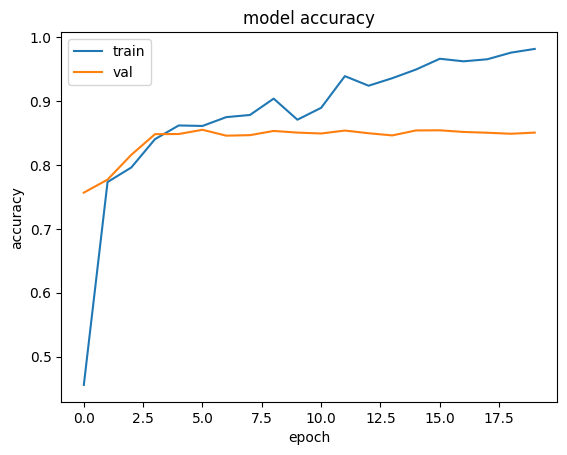

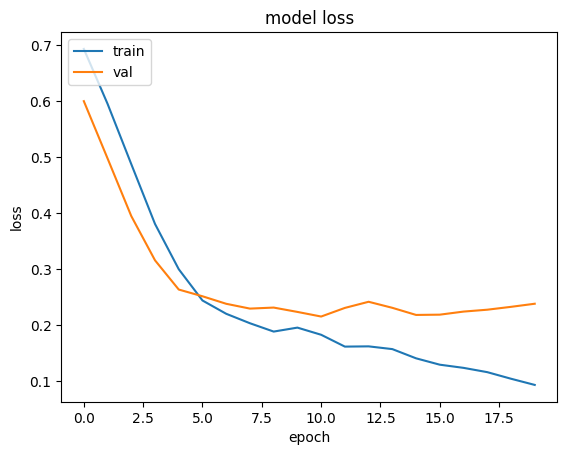

In [8]:
algorithm_learning(context_size, size + 1, input_data, output_data, test_input_data, test_output_data)

In [9]:
# Restore the model
model = tf.keras.models.load_model('./checkpoints/hess_model_{}_{}'.format(context_size, size + 1))

In [10]:
number_of_samples = 1

input_data, output_data, t, universe, subset_solution = gen_data(bits, size, context_size, 1, verbose=True)

print(input_data)
print(output_data)

[79, 143, 26, 44, 104, 104, 25, 169, 37, 87, 142, 196, 46, 120, 229, 199, 164, 130, 109, 39, 83, 9, 116, 13, 129, 232, 104, 29, 226, 251]
1536 1536 [79, 143, 26, 44, 104, 229, 164, 9, 232, 29, 226, 251]
[[[0 0 0 ... 1 1 1]
  [0 0 0 ... 1 1 1]
  [0 0 0 ... 0 1 0]
  ...
  [0 0 0 ... 0 1 0]
  [0 0 0 ... 0 1 1]
  [0 0 0 ... 0 0 0]]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1
  1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1]]


In [11]:
prediction = model.predict(input_data)[0]
subset_prediction = prediction > 0.5
subset_prediction = list(map(int, subset_prediction))
print(subset_prediction)

1/1 [==============================] - 1s 871ms/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1]


In [12]:
print(universe)
print(t)
print(subset_solution)

subset = subset_prediction[-len(universe):]

print(subset)

subset_model = [universe[i] for i in range(len(universe)) if subset[i]]
subset_real = [universe[i] for i in range(len(universe)) if subset_solution[i]]

print(sum(subset_model), sum(subset_real))
print('gap : {}'.format(abs(sum(subset_model) - sum(subset_real))))

[79, 143, 26, 44, 104, 104, 25, 169, 37, 87, 142, 196, 46, 120, 229, 199, 164, 130, 109, 39, 83, 9, 116, 13, 129, 232, 104, 29, 226, 251]
1536
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1]
[0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1]
1864 1536
gap : 328
